In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor

C:\Users\aryav\AppData\Local\Temp\ipykernel_18688\692232756.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [23]:
data = pd.read_csv("data_onehot_x.csv", index_col=0)
data = data.query("num_romantic_involvements != 0")

X = data.drop("longest_relationship_months", axis=1)
y = data["longest_relationship_months"]

In [24]:
X, y

(     is_transfer  commute  minor  is_stem   gpa  club_general  \
 1              0        0      1        1  3.72             1   
 2              0        0      1        1  3.70             1   
 3              0        0      0        1  4.00             1   
 4              0        0      0        1   NaN             1   
 5              0        1      0        1  3.90             1   
 ..           ...      ...    ...      ...   ...           ...   
 99             0        1      0        1  3.30             1   
 103            0        1      0        1  3.40             1   
 106            0        1      1        1  3.30             1   
 108            0        1      0        1   NaN             1   
 109            0        0      0        1  3.70             1   
 
      club_professional  club_recreational  club_athletic  club_cultural  ...  \
 1                    1                  0              0              0  ...   
 2                    1                  0  

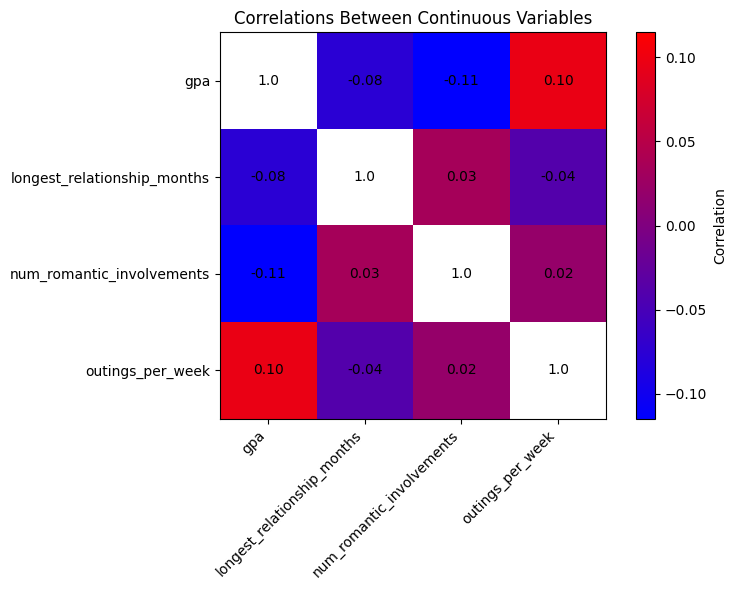

In [25]:
corr_matrix = data[["gpa", "longest_relationship_months", "num_romantic_involvements", "outings_per_week"]].corr().replace(1, np.nan)
range_endpoint = max(np.abs(corr_matrix.min().min()), np.abs(corr_matrix.max().max()))

plt.figure(figsize=(8, 6))

colors_list = [(0, 0, 1), (1, 0, 0)]
custom = LinearSegmentedColormap.from_list("fire_colors", colors_list, N=1000)
plt.imshow(corr_matrix, cmap=custom, vmin=-range_endpoint, vmax=range_endpoint)

plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlations Between Continuous Variables")
# Annotate with correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.index)):
        if np.isnan(corr_matrix.iloc[i, j]): 
            plt.text(j, i, f"1.0", ha="center", va="center", color="w" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black")
            continue
        plt.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="w" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black")
plt.tight_layout()
plt.show()

In [ ]:
supports = np.zeros(X.shape[1])
for x in range(25):
    X_train, X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.1
    )
    model = LinearRegression()
    sfs = SequentialFeatureSelector(model, direction="backward", n_features_to_select=10)
    sfs.fit(X_train, y_train)
    supports += sfs.get_support().astype(int)

support_mask = np.array([False] * X.shape[1])
support_mask[(supports).argsort()[:10]] = np.array([True] * 10)
restricted_X = X[X.columns[support_mask]]
restricted_X

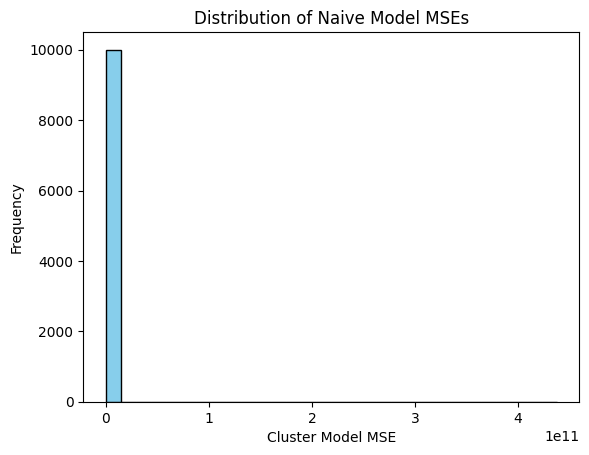

In [ ]:
cluster_MSE = []

for x in range(10000):
    restricted_X_train, restricted_X_test, y_train, y_test = train_test_split(
        X.fillna(0), y, test_size=0.1
    )

    kmeans = KMeans(n_clusters=10)
    kmeans.fit(restricted_X_train)
    train_clusters = kmeans.fit_predict(restricted_X_train)
    test_clusters = kmeans.predict(restricted_X_test)

    cluster_models = {}
    cluster_predictions = np.zeros(len(y_test))

    for cluster_id in range(3):
        cluster_mask_train = train_clusters == cluster_id
        cluster_mask_test = test_clusters == cluster_id
        
        if np.sum(cluster_mask_train) > 1 and np.sum(cluster_mask_test) > 0:
            cluster_model = LinearRegression()
            cluster_model.fit(X_train[cluster_mask_train], y_train[cluster_mask_train])
            cluster_models[cluster_id] = cluster_model
            cluster_predictions[cluster_mask_test] = cluster_model.predict(X_test[cluster_mask_test])
        else:
            cluster_models[cluster_id] = None
            cluster_predictions[cluster_mask_test] = np.mean(y_train[cluster_mask_train])

    cluster_MSE += [mean_squared_error(y_test, cluster_predictions)]

cluster_MSE = np.array(cluster_MSE)

plt.hist(cluster_MSE, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Cluster Model MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Naive Model MSEs')
plt.show()

In [ ]:
naive_MSE = []
coef_dist = []
linear_MSE = []

for x in range(100000):
    restricted_X_train, restricted_X_test, y_train, y_test = train_test_split(
        restricted_X.fillna(0), y, test_size=0.1
    )

    naive_pred = [y_train.mean()] * len(y_test)
    naive_MSE += [mean_squared_error(y_test, naive_pred)]

    model = LinearRegression()
    model.fit(restricted_X_train, y_train)
    linear_pred = model.predict(restricted_X_test)
    linear_MSE += [mean_squared_error(y_test, linear_pred)]
    coef_dist += [model.coef_]

naive_MSE = np.array(naive_MSE)
linear_MSE = np.array(linear_MSE)
coef_dist = np.array(coef_dist)

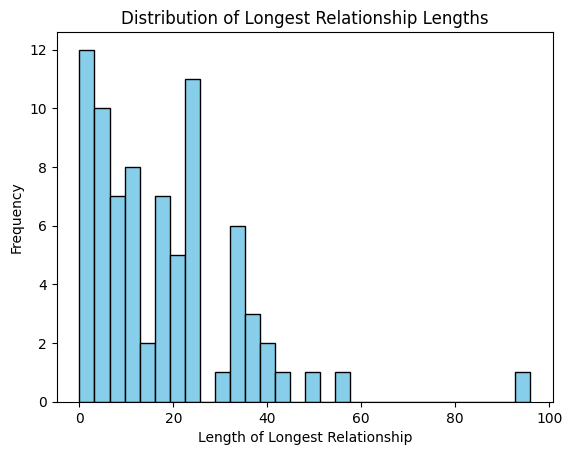

In [172]:
plt.hist(y, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Length of Longest Relationship')
plt.ylabel('Frequency')
plt.title('Distribution of Longest Relationship Lengths')
plt.show()

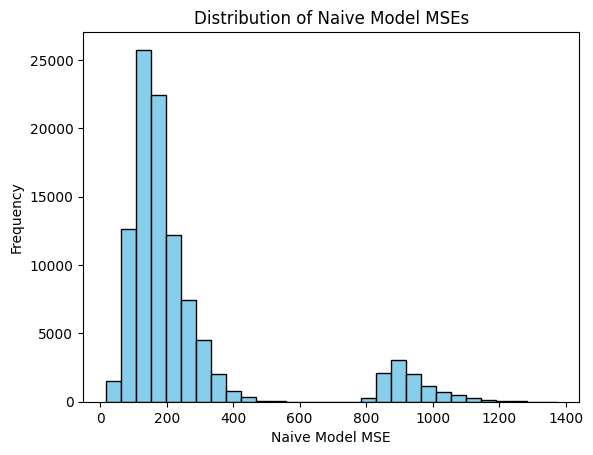

In [ ]:
plt.hist(naive_MSE, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Naive Model MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Naive Model MSEs')
plt.show()

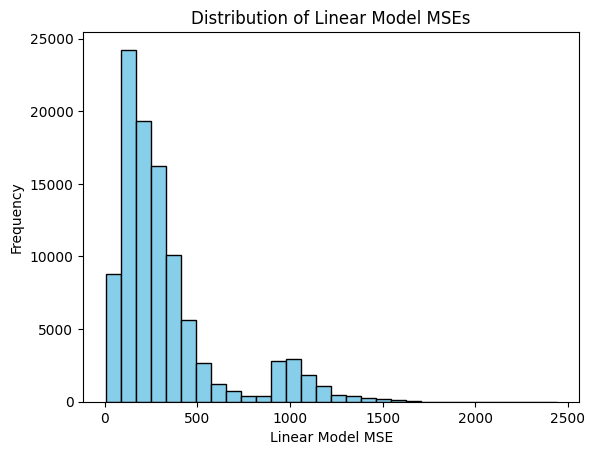

In [93]:
plt.hist(linear_MSE, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Linear Model MSE')
plt.ylabel('Frequency')
plt.title('Distribution of Linear Model MSEs')
plt.show()

$H_0:
\text{The difference in means of MSE }
\mu_{naive} - \mu_{linear} = 0
\text{ and the linear model does not predict relationship lengths better than predicting the average.}$

$H_A: \text{The difference in means of MSE } \mu_{naive} - \mu_{linear} > 0 \text{ and the linear model predicts relationship lengths better than predicting the average.}$

In [ ]:
naive_mean, naive_std = pd.Series(naive_MSE).describe()[["mean", "std"]].to_list()
lin_mean, lin_std = pd.Series(linear_MSE).describe()[["mean", "std"]].to_list()
mean_diff = naive_mean - lin_mean
std_diff = np.sqrt(lin_std**2 + naive_std**2)
print(mean_diff/std_diff)

-0.20027151303176985


The hypothesis test yields a test statistic of -0.2, meaning that we fail to reject the null hypothesis that a linear regression model predicts length of an individual's longest relationship better than solely predicting the mean. 

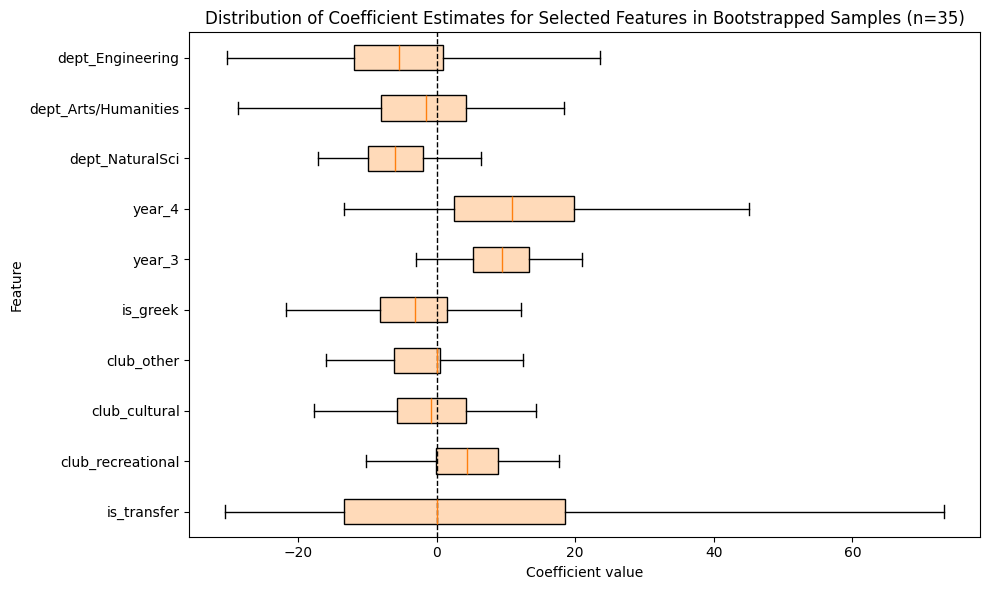

In [ ]:
coef_matrix = []
for x in range(100000):
    # Does bootstrapping make sense here?
    temp_data = np.random.default_rng().choice(
        np.array(pd.concat([restricted_X.fillna(0), y], axis=1)), size=35
    )
    X_train, y_train = temp_data[:, :-1], temp_data[:, -1]
    model = LinearRegression()
    model.fit(X_train, y_train)
    coef_matrix += [model.coef_]
coef_matrix = np.array(coef_matrix)

plt.figure(figsize=(10,6))
blt = plt.boxplot(coef_matrix, whis=(2.5, 97.5), showfliers=False, vert=False, patch_artist=True)
for box in blt['boxes']:
    box.set_facecolor("peachpuff")
    box.set_edgecolor("black")
plt.yticks(
    ticks=np.arange(1, len(restricted_X.columns)+1), 
    labels=restricted_X.columns, 
)
plt.ylabel('Feature')
plt.xlabel('Coefficient value')
plt.title('Distribution of Coefficient Estimates for Selected Features in Bootstrapped Samples (n=35)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

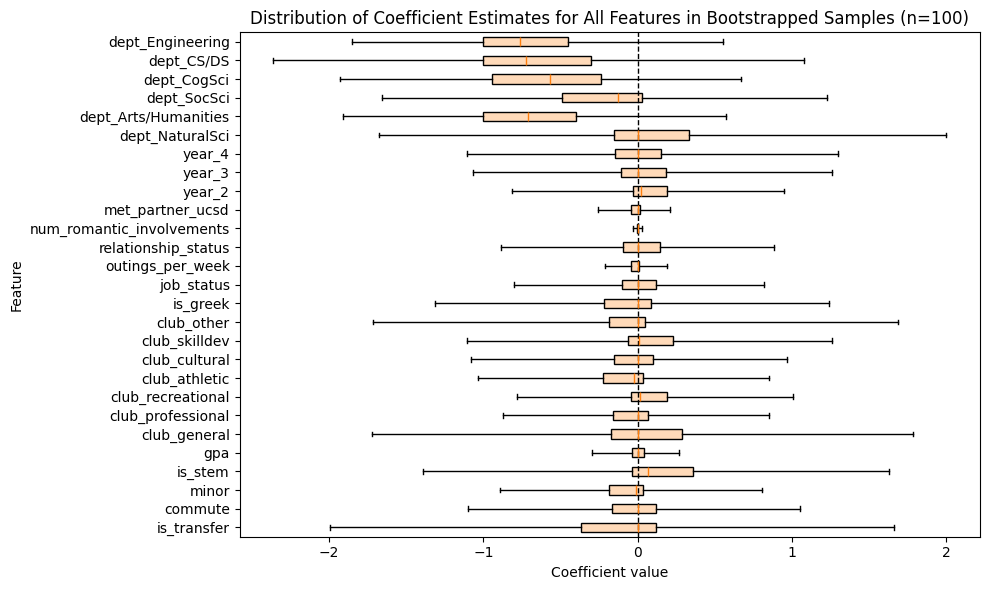

In [ ]:
coef_matrix = []
for x in range(100000):
    # Does bootstrapping make sense here?
    temp_data = np.random.default_rng().choice(
        np.array(data.fillna(0)), size=35
    )
    X_train, y_train = temp_data[:, :-1], temp_data[:, -1]
    model = LinearRegression()
    model.fit(X_train, y_train)
    coef_matrix += [model.coef_]
coef_matrix = np.array(coef_matrix)

plt.figure(figsize=(10,6))
blt = plt.boxplot(coef_matrix, whis=(2.5, 97.5), showfliers=False, vert=False, patch_artist=True)
for box in blt['boxes']:
    box.set_facecolor("peachpuff")
    box.set_edgecolor("black")
plt.yticks(
    ticks=np.arange(1, len(X.columns)+1), 
    labels=X.columns
)
plt.ylabel('Feature')
plt.xlabel('Coefficient value')
plt.title('Distribution of Coefficient Estimates for All Features in Bootstrapped Samples (n=100)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

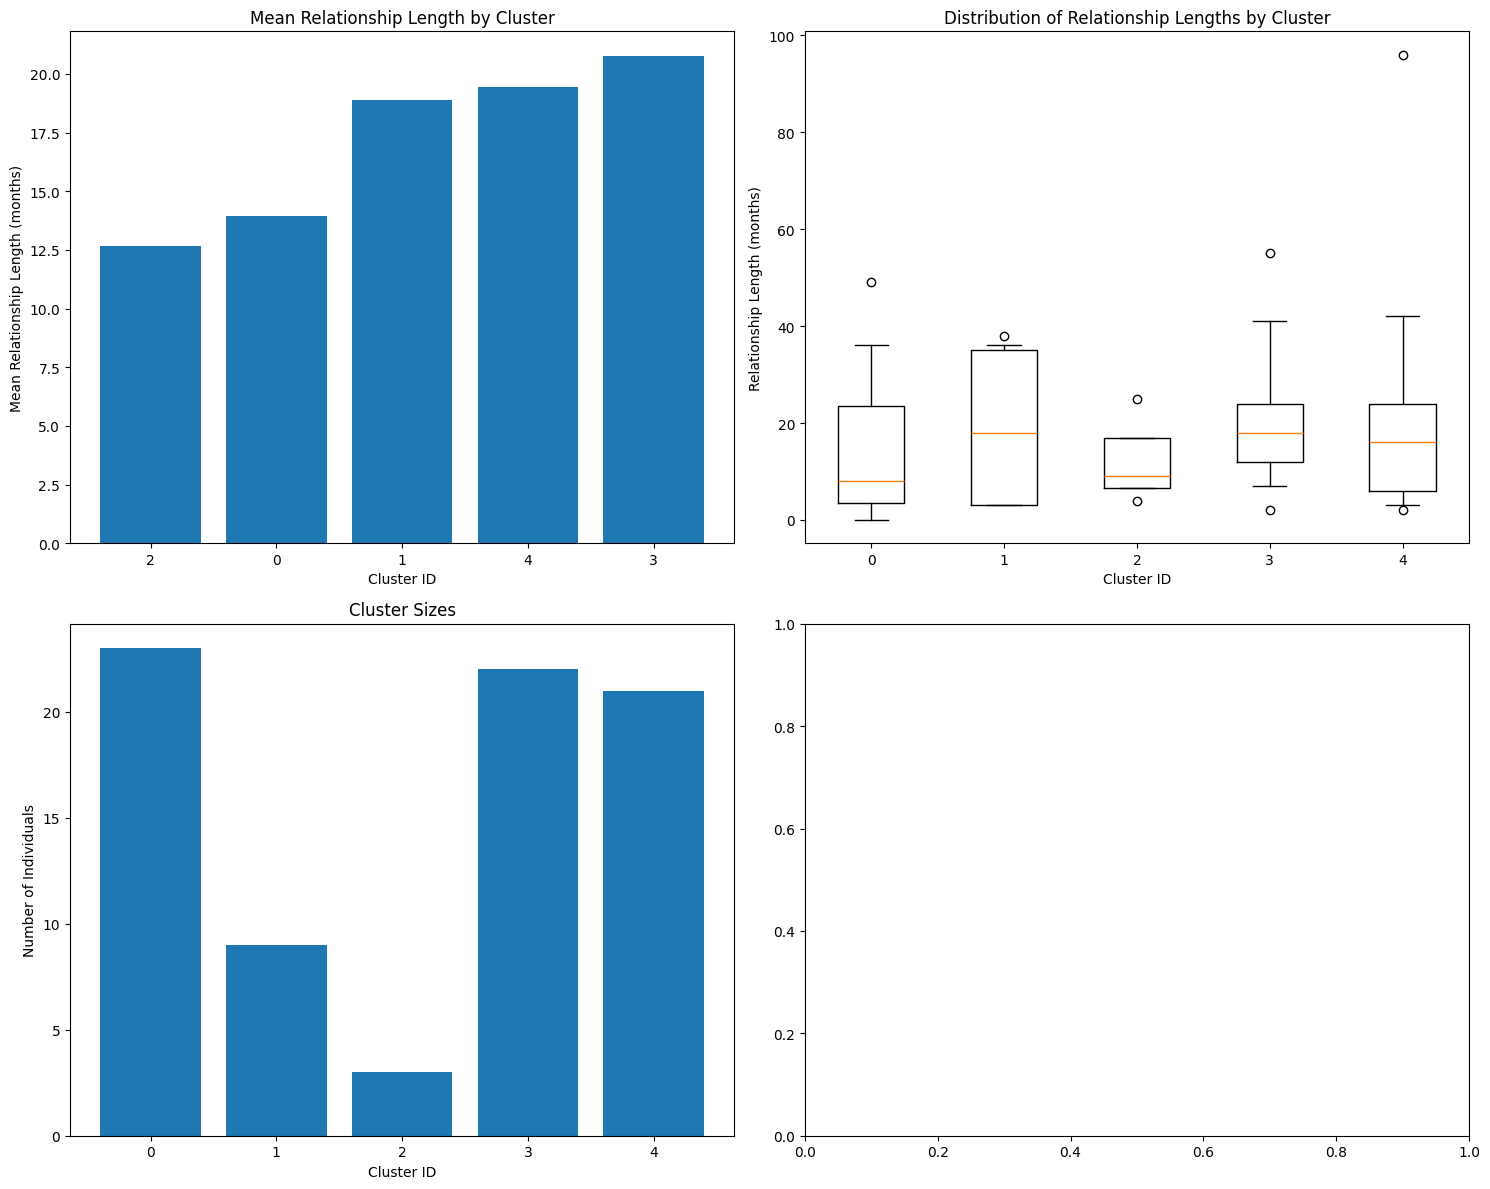


Cluster Statistics:

Cluster 0:
  Size: 23 individuals
  Mean relationship length: 13.96 months
  Median relationship length: 8.00 months
  Std relationship length: 14.01 months
  Mean romantic involvements: -0.30

Cluster 1:
  Size: 9 individuals
  Mean relationship length: 18.89 months
  Median relationship length: 18.00 months
  Std relationship length: 15.89 months
  Mean romantic involvements: 1.52

Cluster 2:
  Size: 3 individuals
  Mean relationship length: 12.67 months
  Median relationship length: 9.00 months
  Std relationship length: 10.97 months
  Mean romantic involvements: -0.71

Cluster 3:
  Size: 22 individuals
  Mean relationship length: 20.77 months
  Median relationship length: 18.00 months
  Std relationship length: 12.38 months
  Mean romantic involvements: -0.22

Cluster 4:
  Size: 21 individuals
  Mean relationship length: 19.45 months
  Median relationship length: 16.00 months
  Std relationship length: 20.86 months
  Mean romantic involvements: 0.01


In [292]:
scaled_data = X.drop("gpa", axis=1)
scaled_data = (scaled_data - scaled_data.mean())/scaled_data.std()

kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_data)

scaled_data["predicted_cluster"] = kmeans.predict(scaled_data)
data_with_clusters = pd.concat([scaled_data, y], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean relationship length by cluster
cluster_means = data_with_clusters.groupby('predicted_cluster')['longest_relationship_months'].mean().sort_values()
axes[0, 0].bar(range(len(cluster_means)), cluster_means.values)
axes[0, 0].set_xlabel('Cluster ID')
axes[0, 0].set_ylabel('Mean Relationship Length (months)')
axes[0, 0].set_title('Mean Relationship Length by Cluster')
axes[0, 0].set_xticks(range(len(cluster_means)))
axes[0, 0].set_xticklabels(cluster_means.index)

# 2. Distribution of relationship lengths in each cluster
cluster_data = [data_with_clusters[data_with_clusters['predicted_cluster'] == c]['longest_relationship_months'].values 
                for c in sorted(data_with_clusters['predicted_cluster'].unique())]
axes[0, 1].boxplot(cluster_data, whis=(2.5, 97.5), showfliers=True, labels=sorted(data_with_clusters['predicted_cluster'].unique()))
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Relationship Length (months)')
axes[0, 1].set_title('Distribution of Relationship Lengths by Cluster')

# 3. Cluster sizes
cluster_sizes = data_with_clusters['predicted_cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_sizes.index, cluster_sizes.values)
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Number of Individuals')
axes[1, 0].set_title('Cluster Sizes')

plt.tight_layout()
plt.show()

# Print cluster statistics
print("\nCluster Statistics:")
print("=" * 60)
for cluster_id in sorted(data_with_clusters['predicted_cluster'].unique()):
    cluster_data = data_with_clusters[data_with_clusters['predicted_cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data)} individuals")
    print(f"  Mean relationship length: {cluster_data['longest_relationship_months'].mean():.2f} months")
    print(f"  Median relationship length: {cluster_data['longest_relationship_months'].median():.2f} months")
    print(f"  Std relationship length: {cluster_data['longest_relationship_months'].std():.2f} months")
    
    # Show some key characteristics
    if 'gpa' in cluster_data.columns:
        print(f"  Mean GPA: {cluster_data['gpa'].mean():.2f}")
    if 'num_romantic_involvements' in cluster_data.columns:
        print(f"  Mean romantic involvements: {cluster_data['num_romantic_involvements'].mean():.2f}")

### Last-minute things to try ###
- NegativeBinomial
- Cluster significance test